
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


In [1]:
!nvidia-smi

Wed Mar 18 14:43:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Data Loading
We provide the code for data loading.

In [3]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


# Simple GAN

Specify the generator and the discriminator to get the following architectures:

```
 Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
```


```
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)
```

We recommend the use of leaky-relu for the hidden layers and tanh for the last layer of the generator. We let you chose the appropriate activation for the last layer of the discriminator. We also recommend using dropout(0.3) in the discriminator.


In [0]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(in_features=g_input_dim, out_features=256, bias=True)
        self.fc2 = nn.Linear(in_features=256, out_features=512, bias=True)
        self.fc3 = nn.Linear(in_features=512, out_features=1024, bias=True)
        self.fc4 = nn.Linear(in_features=1024, out_features=g_output_dim, bias=True)
 
    # forward method
    def forward(self, x): 
        A1 = F.leaky_relu(self.fc1(x),0.2)
        A2 = F.leaky_relu(self.fc2(A1),0.2)
        A3 = F.leaky_relu(self.fc3(A2),0.2)

        return torch.tanh(self.fc4(A3))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(in_features=d_input_dim, out_features=1024, bias=True)
        self.fc2 = nn.Linear(in_features=1024, out_features=512, bias=True)
        self.fc3 = nn.Linear(in_features=512, out_features=256, bias=True)
        self.fc4 = nn.Linear(in_features=256, out_features=1, bias=True)
    
    # forward method
    def forward(self, x):
        A1 = F.leaky_relu(self.fc1(x),0.2)
        A1 = F.dropout(A1, 0.3)
        A2 = F.leaky_relu(self.fc2(A1),0.2)
        A2 = F.dropout(A2, 0.3)
        A3 = F.leaky_relu(self.fc3(A2),0.2)
        A3 = F.dropout(A3, 0.3)

        return torch.sigmoid(self.fc4(A3))

## Networks

In [0]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

## Training 
Chose the discriminator loss.

In [0]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

Now, let's code the discriminator update

In [0]:
def D_train(x): # x is a batch composed of images
    #=======================Train the discriminator=======================#
    D.zero_grad()
    
    # train discriminator on real
    x_real = x.view(-1, mnist_dim)
    y_real = torch.ones(bs, 1)  # labels 1 for real images
    x_real = Variable(x_real.to(device))
    y_real = Variable(y_real.to(device))
    D_output    = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake
    z           = Variable(torch.randn(bs, z_dim).to(device))
    x_fake      = G(z) # generate fake images
    y_fake      = Variable(torch.zeros(bs, 1).to(device)) # labels 0 for fake images
    D_output    = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

Now, let's code the generator update

In [0]:
def G_train():
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss   = criterion(D_output, y) 
    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

We provide this visualization function.

In [0]:
# Plot the loss from each batch
def plotLoss(dLosses,gLosses):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminative loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    plt.figure(figsize=figsize)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Finally, this is the main loop:

EPOCH 1 :
  [    0/60000 ( 0%)]	loss_D: 1.373, loss_G: 0.671
  [10000/60000 (17%)]	loss_D: 0.996, loss_G: 1.176
  [20000/60000 (33%)]	loss_D: 1.094, loss_G: 1.509
  [30000/60000 (50%)]	loss_D: 1.004, loss_G: 2.289
  [40000/60000 (67%)]	loss_D: 0.862, loss_G: 3.212
  [50000/60000 (83%)]	loss_D: 0.874, loss_G: 3.133


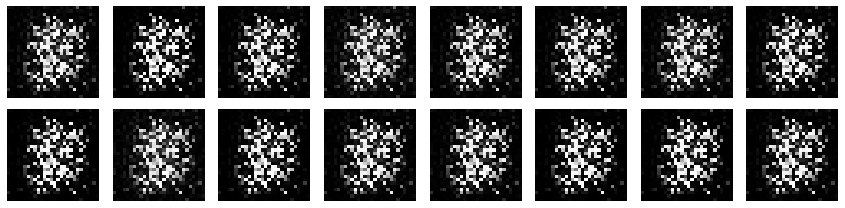

EPOCH 2 :
  [    0/60000 ( 0%)]	loss_D: 0.407, loss_G: 4.164
  [10000/60000 (17%)]	loss_D: 0.812, loss_G: 3.805
  [20000/60000 (33%)]	loss_D: 0.917, loss_G: 3.297
  [30000/60000 (50%)]	loss_D: 0.925, loss_G: 2.998
  [40000/60000 (67%)]	loss_D: 0.938, loss_G: 2.689
  [50000/60000 (83%)]	loss_D: 0.951, loss_G: 2.492


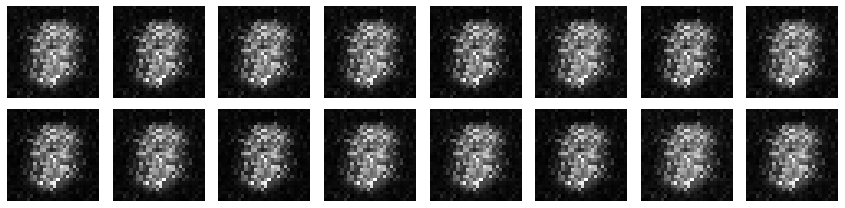

EPOCH 3 :
  [    0/60000 ( 0%)]	loss_D: 1.575, loss_G: 0.800
  [10000/60000 (17%)]	loss_D: 1.009, loss_G: 1.800
  [20000/60000 (33%)]	loss_D: 1.125, loss_G: 1.638
  [30000/60000 (50%)]	loss_D: 1.104, loss_G: 1.510
  [40000/60000 (67%)]	loss_D: 1.062, loss_G: 1.589
  [50000/60000 (83%)]	loss_D: 1.059, loss_G: 1.610


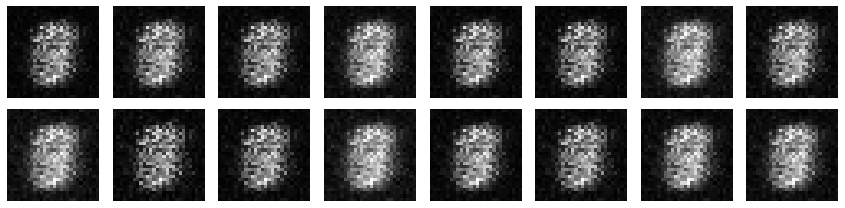

EPOCH 4 :
  [    0/60000 ( 0%)]	loss_D: 0.831, loss_G: 3.392
  [10000/60000 (17%)]	loss_D: 0.769, loss_G: 2.258
  [20000/60000 (33%)]	loss_D: 0.922, loss_G: 2.513
  [30000/60000 (50%)]	loss_D: 0.871, loss_G: 2.458
  [40000/60000 (67%)]	loss_D: 0.797, loss_G: 2.582
  [50000/60000 (83%)]	loss_D: 0.749, loss_G: 2.563


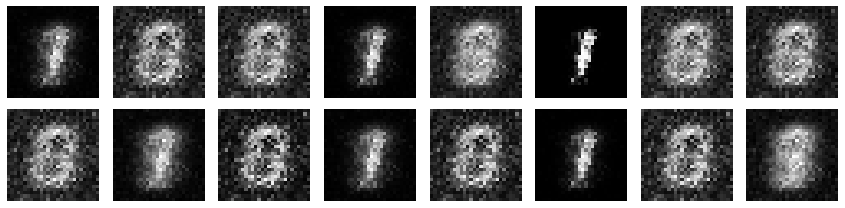

EPOCH 5 :
  [    0/60000 ( 0%)]	loss_D: 0.478, loss_G: 2.850
  [10000/60000 (17%)]	loss_D: 0.529, loss_G: 2.679
  [20000/60000 (33%)]	loss_D: 0.490, loss_G: 2.812
  [30000/60000 (50%)]	loss_D: 0.483, loss_G: 2.860
  [40000/60000 (67%)]	loss_D: 0.473, loss_G: 2.853
  [50000/60000 (83%)]	loss_D: 0.488, loss_G: 2.949


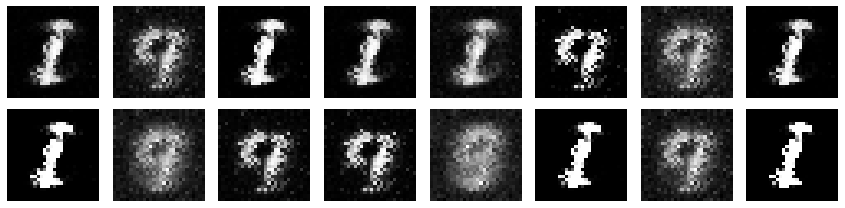

EPOCH 6 :
  [    0/60000 ( 0%)]	loss_D: 0.554, loss_G: 1.950
  [10000/60000 (17%)]	loss_D: 0.445, loss_G: 3.252
  [20000/60000 (33%)]	loss_D: 0.493, loss_G: 2.752
  [30000/60000 (50%)]	loss_D: 0.503, loss_G: 2.708
  [40000/60000 (67%)]	loss_D: 0.537, loss_G: 2.640
  [50000/60000 (83%)]	loss_D: 0.527, loss_G: 2.664


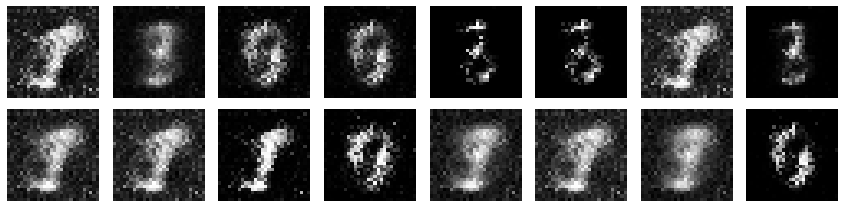

EPOCH 7 :
  [    0/60000 ( 0%)]	loss_D: 0.988, loss_G: 1.599
  [10000/60000 (17%)]	loss_D: 0.571, loss_G: 2.834
  [20000/60000 (33%)]	loss_D: 0.558, loss_G: 2.711
  [30000/60000 (50%)]	loss_D: 0.534, loss_G: 2.713
  [40000/60000 (67%)]	loss_D: 0.523, loss_G: 2.791
  [50000/60000 (83%)]	loss_D: 0.511, loss_G: 2.873


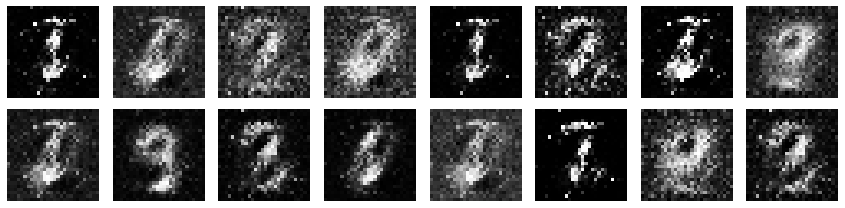

EPOCH 8 :
  [    0/60000 ( 0%)]	loss_D: 0.590, loss_G: 2.025
  [10000/60000 (17%)]	loss_D: 0.656, loss_G: 2.416
  [20000/60000 (33%)]	loss_D: 0.603, loss_G: 2.515
  [30000/60000 (50%)]	loss_D: 0.584, loss_G: 2.561
  [40000/60000 (67%)]	loss_D: 0.586, loss_G: 2.603
  [50000/60000 (83%)]	loss_D: 0.583, loss_G: 2.618


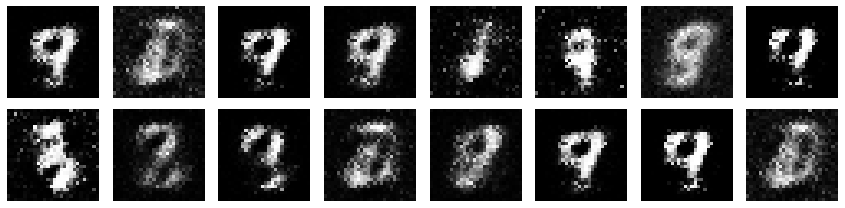

EPOCH 9 :
  [    0/60000 ( 0%)]	loss_D: 0.619, loss_G: 3.053
  [10000/60000 (17%)]	loss_D: 0.505, loss_G: 2.570
  [20000/60000 (33%)]	loss_D: 0.515, loss_G: 2.700
  [30000/60000 (50%)]	loss_D: 0.534, loss_G: 2.780
  [40000/60000 (67%)]	loss_D: 0.548, loss_G: 2.688
  [50000/60000 (83%)]	loss_D: 0.529, loss_G: 2.728


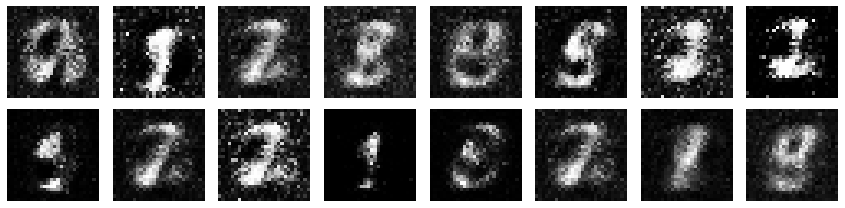

EPOCH 10 :
  [    0/60000 ( 0%)]	loss_D: 0.528, loss_G: 2.755
  [10000/60000 (17%)]	loss_D: 0.632, loss_G: 2.437
  [20000/60000 (33%)]	loss_D: 0.614, loss_G: 2.419
  [30000/60000 (50%)]	loss_D: 0.663, loss_G: 2.312
  [40000/60000 (67%)]	loss_D: 0.696, loss_G: 2.181
  [50000/60000 (83%)]	loss_D: 0.691, loss_G: 2.160


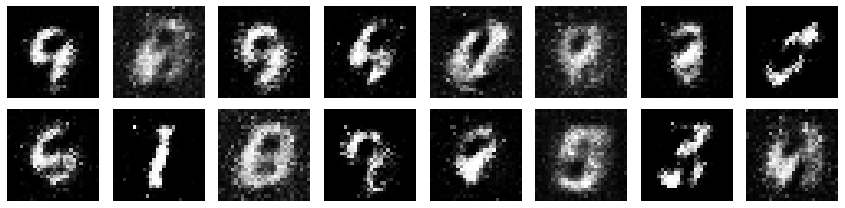

EPOCH 11 :
  [    0/60000 ( 0%)]	loss_D: 0.663, loss_G: 2.711
  [10000/60000 (17%)]	loss_D: 0.692, loss_G: 2.030
  [20000/60000 (33%)]	loss_D: 0.754, loss_G: 2.032
  [30000/60000 (50%)]	loss_D: 0.734, loss_G: 2.032
  [40000/60000 (67%)]	loss_D: 0.712, loss_G: 2.087
  [50000/60000 (83%)]	loss_D: 0.703, loss_G: 2.109


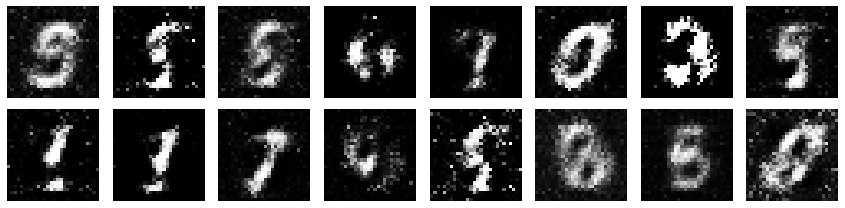

EPOCH 12 :
  [    0/60000 ( 0%)]	loss_D: 0.691, loss_G: 2.362
  [10000/60000 (17%)]	loss_D: 0.811, loss_G: 1.953
  [20000/60000 (33%)]	loss_D: 0.732, loss_G: 2.038
  [30000/60000 (50%)]	loss_D: 0.686, loss_G: 2.138
  [40000/60000 (67%)]	loss_D: 0.704, loss_G: 2.148
  [50000/60000 (83%)]	loss_D: 0.708, loss_G: 2.129


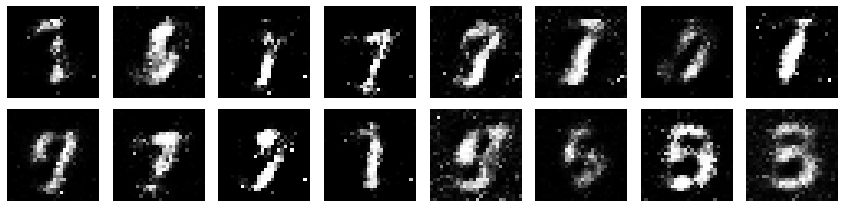

EPOCH 13 :
  [    0/60000 ( 0%)]	loss_D: 0.454, loss_G: 2.075
  [10000/60000 (17%)]	loss_D: 0.687, loss_G: 2.172
  [20000/60000 (33%)]	loss_D: 0.708, loss_G: 2.182
  [30000/60000 (50%)]	loss_D: 0.712, loss_G: 2.166
  [40000/60000 (67%)]	loss_D: 0.697, loss_G: 2.198
  [50000/60000 (83%)]	loss_D: 0.702, loss_G: 2.165


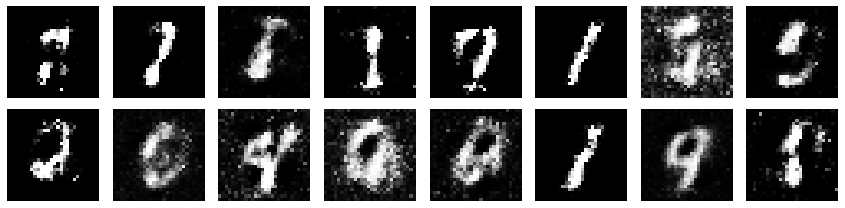

EPOCH 14 :
  [    0/60000 ( 0%)]	loss_D: 0.836, loss_G: 1.836
  [10000/60000 (17%)]	loss_D: 0.757, loss_G: 1.922
  [20000/60000 (33%)]	loss_D: 0.741, loss_G: 1.961
  [30000/60000 (50%)]	loss_D: 0.726, loss_G: 2.019
  [40000/60000 (67%)]	loss_D: 0.713, loss_G: 2.070
  [50000/60000 (83%)]	loss_D: 0.698, loss_G: 2.108


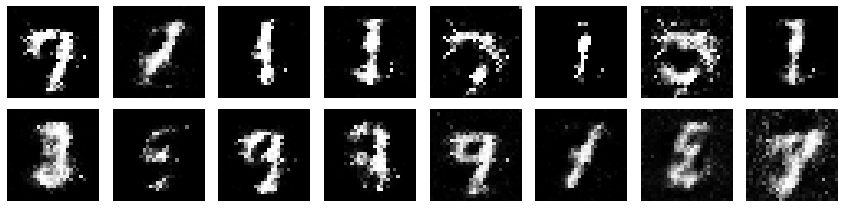

EPOCH 15 :
  [    0/60000 ( 0%)]	loss_D: 0.719, loss_G: 2.260
  [10000/60000 (17%)]	loss_D: 0.692, loss_G: 2.168
  [20000/60000 (33%)]	loss_D: 0.738, loss_G: 2.061
  [30000/60000 (50%)]	loss_D: 0.753, loss_G: 1.989
  [40000/60000 (67%)]	loss_D: 0.758, loss_G: 1.979
  [50000/60000 (83%)]	loss_D: 0.762, loss_G: 1.958


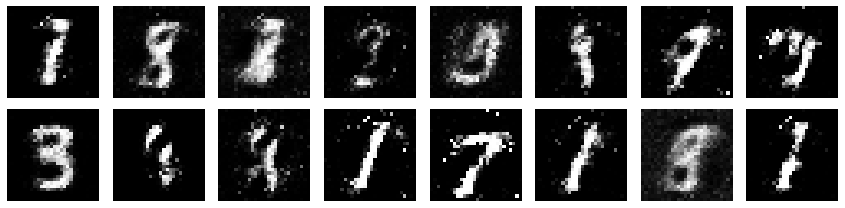

EPOCH 16 :
  [    0/60000 ( 0%)]	loss_D: 1.062, loss_G: 1.760
  [10000/60000 (17%)]	loss_D: 0.799, loss_G: 2.023
  [20000/60000 (33%)]	loss_D: 0.816, loss_G: 1.902
  [30000/60000 (50%)]	loss_D: 0.822, loss_G: 1.850
  [40000/60000 (67%)]	loss_D: 0.814, loss_G: 1.841
  [50000/60000 (83%)]	loss_D: 0.812, loss_G: 1.834


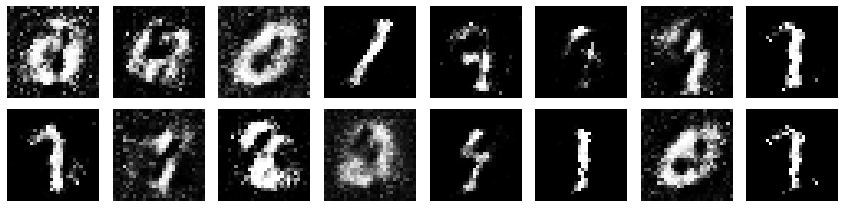

EPOCH 17 :
  [    0/60000 ( 0%)]	loss_D: 0.850, loss_G: 1.798
  [10000/60000 (17%)]	loss_D: 0.812, loss_G: 1.815
  [20000/60000 (33%)]	loss_D: 0.788, loss_G: 1.873
  [30000/60000 (50%)]	loss_D: 0.793, loss_G: 1.860
  [40000/60000 (67%)]	loss_D: 0.805, loss_G: 1.811
  [50000/60000 (83%)]	loss_D: 0.803, loss_G: 1.821


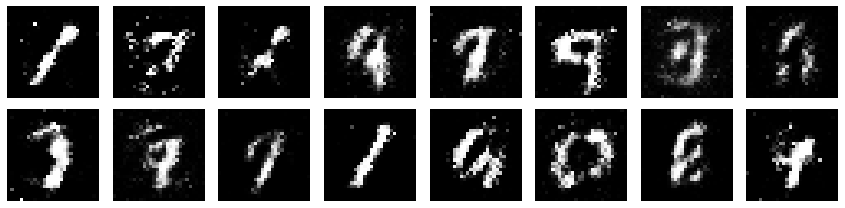

EPOCH 18 :
  [    0/60000 ( 0%)]	loss_D: 0.647, loss_G: 1.764
  [10000/60000 (17%)]	loss_D: 0.835, loss_G: 1.780
  [20000/60000 (33%)]	loss_D: 0.824, loss_G: 1.806
  [30000/60000 (50%)]	loss_D: 0.830, loss_G: 1.773
  [40000/60000 (67%)]	loss_D: 0.823, loss_G: 1.790
  [50000/60000 (83%)]	loss_D: 0.827, loss_G: 1.792


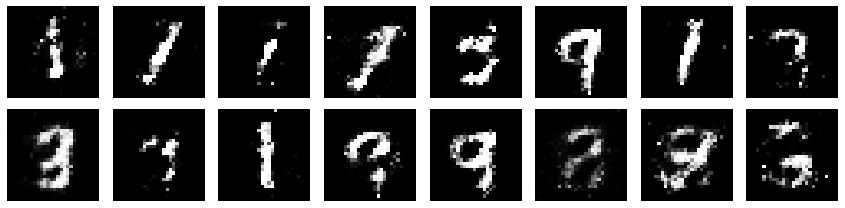

EPOCH 19 :
  [    0/60000 ( 0%)]	loss_D: 0.977, loss_G: 1.964
  [10000/60000 (17%)]	loss_D: 0.853, loss_G: 1.612
  [20000/60000 (33%)]	loss_D: 0.864, loss_G: 1.613
  [30000/60000 (50%)]	loss_D: 0.870, loss_G: 1.637
  [40000/60000 (67%)]	loss_D: 0.865, loss_G: 1.659
  [50000/60000 (83%)]	loss_D: 0.882, loss_G: 1.635


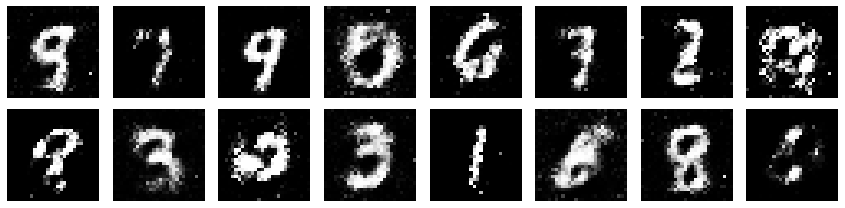

EPOCH 20 :
  [    0/60000 ( 0%)]	loss_D: 1.137, loss_G: 1.460
  [10000/60000 (17%)]	loss_D: 0.911, loss_G: 1.619
  [20000/60000 (33%)]	loss_D: 0.889, loss_G: 1.651
  [30000/60000 (50%)]	loss_D: 0.899, loss_G: 1.627
  [40000/60000 (67%)]	loss_D: 0.902, loss_G: 1.611
  [50000/60000 (83%)]	loss_D: 0.903, loss_G: 1.604


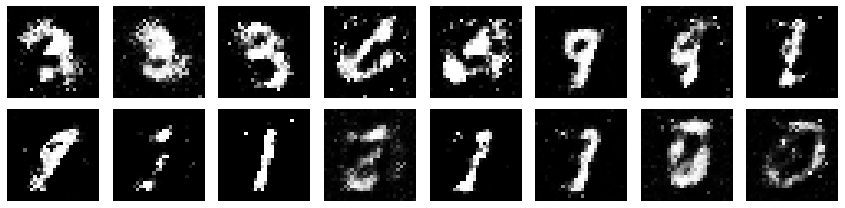

In [10]:
n_epoch = 20
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    print('EPOCH %d :' % epoch)
    for batch_idx, (x, _) in enumerate(train_loader):
        loss_D = D_train(x)
        D_losses.append(loss_D)
        loss_G = G_train()
        G_losses.append(loss_G)
        
        if batch_idx % 100 == 0:
            print('  [{:5d}/{} ({:2.0f}%)]\tloss_D: {:.3f}, loss_G: {:.3f}'.format(batch_idx * len(x), len(train_loader.dataset), 100. * batch_idx / len(train_loader), torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G(test_z)
        sub_generated = generated[:16,:]
        plotGeneratedImages(sub_generated.view(sub_generated.size(0), 1, 28, 28),dim=(2, 8),figsize=(12,3))


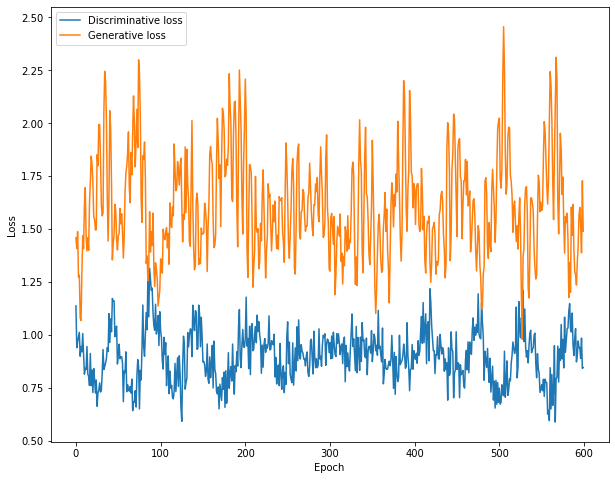

In [11]:
plotLoss(D_losses, G_losses)

# DCGAN

Now, we will implement a version of GAN that uses convolutions: DCGAN. You can find the paper [here](https://arxiv.org/abs/1511.06434). The main idea of DCGAN is to use convolutions in the generator and discriminator in order to get images that are more spacially consistent. Replace your naive generator and decoder by the DCGAN architectures. This is slower to train but by looking at the images after one epoch, you can already draw an interesting conclusion. The architecture is not clearly specified for mnist. You can use the following generator (use leakyRelu):


*   Dense(128x7x7) 
*   UpSampling2D
*   Conv2D(64, kernel_size=(5, 5)
*   UpSampling2D
*   Conv2D(1, kernel_size=(5, 5) 

Use a tanh activation at the end.

For the discriminator:


* Conv2D(64, kernel_size=(5, 5), strides=(2, 2)
* Conv2D(128, kernel_size=(5, 5), strides=(2, 2)
* Dense(1, activation='sigmoid'))


In [0]:
class Generator_DCGAN(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator_DCGAN, self).__init__()       
        #self.d0  = nn.Dropout(0.3)
        self.fc1 = nn.Linear(in_features=g_input_dim,  out_features=128*7*7, bias=True)
        self.b1  = nn.BatchNorm2d(128)
        self.up2 = nn.Upsample(scale_factor=(2, 2))
        self.c3  = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(5, 5), padding=2, bias=True)
        self.b2  = nn.BatchNorm2d(64)
        self.up4 = nn.Upsample(scale_factor=(2, 2))
        self.c5  = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(5, 5), padding=2, bias=True)
        
    # forward method
    def forward(self, x): 
        #x = self.d1(x)
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1, 128, 7, 7)
        x = self.b1(x)
        x = self.up2(x)
        x = F.leaky_relu(self.c3(x))
        x = self.b2(x)
        x = self.up4(x)
        x = torch.tanh(self.c5(x))
        return x
    
class Discriminator_DCGAN(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator_DCGAN, self).__init__()
        self.c1  = nn.Conv2d(in_channels=1, out_channels=64,  kernel_size=(5, 5), stride=(2, 2), padding=2, bias=True)
        self.c2  = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2), padding=2, bias=True)
        self.fl3 = nn.Flatten()
        self.fc4 = nn.Linear(in_features=128*7*7, out_features=1,  bias=True)
        
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.c1(x))
        x = F.leaky_relu(self.c2(x))
        x = self.fl3(x)
        x = torch.sigmoid(self.fc4(x)) # (torch.tanh(self.fc4(x)) + 1) / 2
        return x

## Network

In [0]:
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G_DCGAN = Generator_DCGAN(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D_DCGAN = Discriminator_DCGAN(mnist_dim).to(device)

## Training

In [0]:
# loss
criterion = F.binary_cross_entropy

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G_DCGAN.parameters(), lr=lr)
D_optimizer = optim.Adam(D_DCGAN.parameters(), lr=lr)

In [0]:
def D_train_DCGAN(x): # x is a batch composed of images
    #=======================Train the discriminator=======================#
    D_DCGAN.zero_grad()
    
    # train discriminator on real
    x_real = x.view(-1, 1, 28, 28)
    y_real = torch.ones(bs, 1)  # labels 1 for real images
    x_real = Variable(x_real.to(device))
    y_real = Variable(y_real.to(device))
    D_output    = D_DCGAN(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake
    z           = Variable(torch.randn(bs, z_dim).to(device))
    x_fake      = G_DCGAN(z) # generate fake images
    y_fake      = Variable(torch.zeros(bs, 1).to(device)) # labels 0 for fake images
    D_output    = D_DCGAN(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [0]:
def G_train_DCGAN():
    #=======================Train the generator=======================#
    G_DCGAN.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = torch.ones((bs, 1)).to(device)

    G_output = G_DCGAN(z)
    D_output = D_DCGAN(G_output)
    G_loss   = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

EPOCH 1 :
  [    0/60000 ( 0%)]	loss_D: 1.379, loss_G: 0.681
  [10000/60000 (17%)]	loss_D: 0.308, loss_G: 2.754
  [20000/60000 (33%)]	loss_D: 0.535, loss_G: 2.435
  [30000/60000 (50%)]	loss_D: 0.730, loss_G: 2.127
  [40000/60000 (67%)]	loss_D: 0.852, loss_G: 1.876
  [50000/60000 (83%)]	loss_D: 0.900, loss_G: 1.770


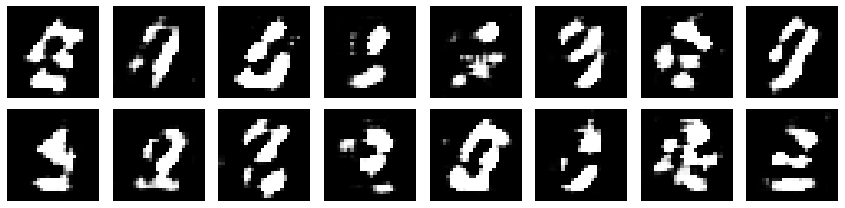

EPOCH 2 :
  [    0/60000 ( 0%)]	loss_D: 1.155, loss_G: 1.106
  [10000/60000 (17%)]	loss_D: 1.126, loss_G: 1.432
  [20000/60000 (33%)]	loss_D: 1.027, loss_G: 1.439
  [30000/60000 (50%)]	loss_D: 1.077, loss_G: 1.537
  [40000/60000 (67%)]	loss_D: 1.054, loss_G: 1.557
  [50000/60000 (83%)]	loss_D: 1.037, loss_G: 1.576


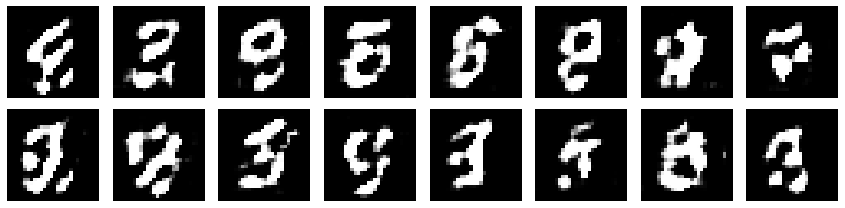

EPOCH 3 :
  [    0/60000 ( 0%)]	loss_D: 0.747, loss_G: 2.359
  [10000/60000 (17%)]	loss_D: 0.756, loss_G: 1.762
  [20000/60000 (33%)]	loss_D: 0.767, loss_G: 1.833
  [30000/60000 (50%)]	loss_D: 0.790, loss_G: 1.868
  [40000/60000 (67%)]	loss_D: 0.828, loss_G: 1.793
  [50000/60000 (83%)]	loss_D: 0.873, loss_G: 1.808


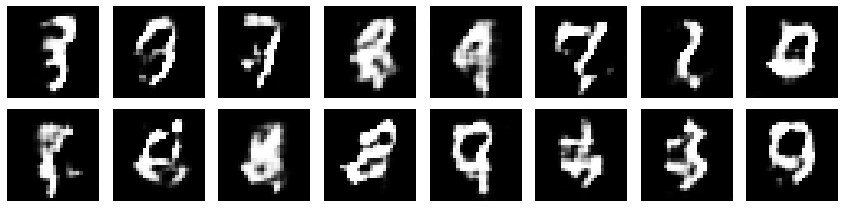

EPOCH 4 :
  [    0/60000 ( 0%)]	loss_D: 1.030, loss_G: 1.206
  [10000/60000 (17%)]	loss_D: 1.057, loss_G: 1.369
  [20000/60000 (33%)]	loss_D: 1.029, loss_G: 1.438
  [30000/60000 (50%)]	loss_D: 1.054, loss_G: 1.414
  [40000/60000 (67%)]	loss_D: 1.068, loss_G: 1.370
  [50000/60000 (83%)]	loss_D: 1.070, loss_G: 1.339


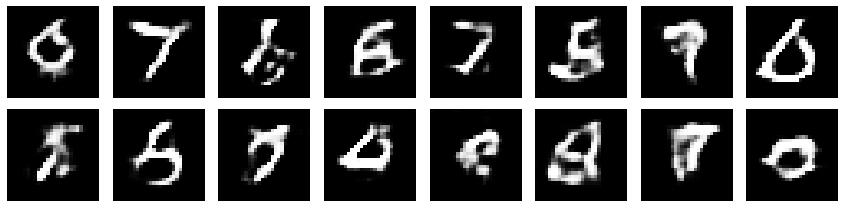

EPOCH 5 :
  [    0/60000 ( 0%)]	loss_D: 1.041, loss_G: 1.352
  [10000/60000 (17%)]	loss_D: 0.985, loss_G: 1.272
  [20000/60000 (33%)]	loss_D: 0.996, loss_G: 1.272
  [30000/60000 (50%)]	loss_D: 1.008, loss_G: 1.256
  [40000/60000 (67%)]	loss_D: 1.016, loss_G: 1.270
  [50000/60000 (83%)]	loss_D: 1.020, loss_G: 1.286


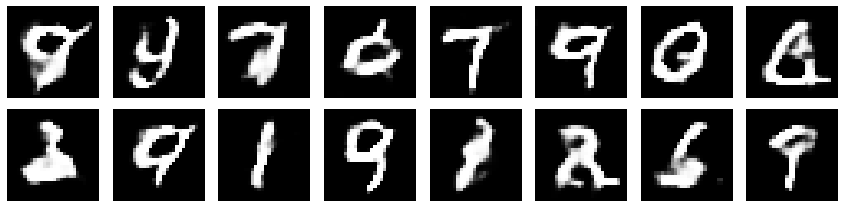

EPOCH 6 :
  [    0/60000 ( 0%)]	loss_D: 1.246, loss_G: 1.125
  [10000/60000 (17%)]	loss_D: 1.065, loss_G: 1.180
  [20000/60000 (33%)]	loss_D: 1.056, loss_G: 1.197
  [30000/60000 (50%)]	loss_D: 1.058, loss_G: 1.192
  [40000/60000 (67%)]	loss_D: 1.054, loss_G: 1.187
  [50000/60000 (83%)]	loss_D: 1.049, loss_G: 1.191


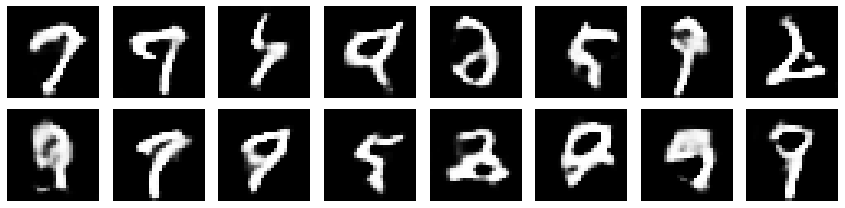

EPOCH 7 :
  [    0/60000 ( 0%)]	loss_D: 1.057, loss_G: 1.070
  [10000/60000 (17%)]	loss_D: 1.041, loss_G: 1.117
  [20000/60000 (33%)]	loss_D: 1.043, loss_G: 1.109
  [30000/60000 (50%)]	loss_D: 1.039, loss_G: 1.116
  [40000/60000 (67%)]	loss_D: 1.035, loss_G: 1.119
  [50000/60000 (83%)]	loss_D: 1.032, loss_G: 1.127


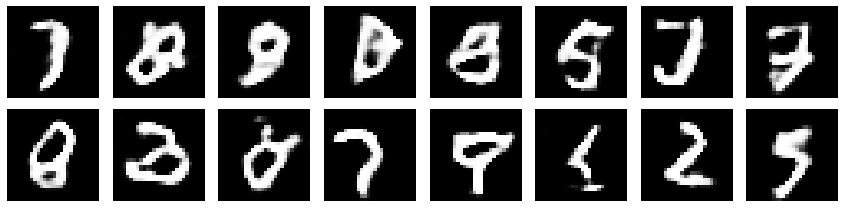

EPOCH 8 :
  [    0/60000 ( 0%)]	loss_D: 0.933, loss_G: 1.510
  [10000/60000 (17%)]	loss_D: 1.005, loss_G: 1.268
  [20000/60000 (33%)]	loss_D: 1.005, loss_G: 1.229
  [30000/60000 (50%)]	loss_D: 0.997, loss_G: 1.212
  [40000/60000 (67%)]	loss_D: 0.993, loss_G: 1.216
  [50000/60000 (83%)]	loss_D: 0.987, loss_G: 1.245


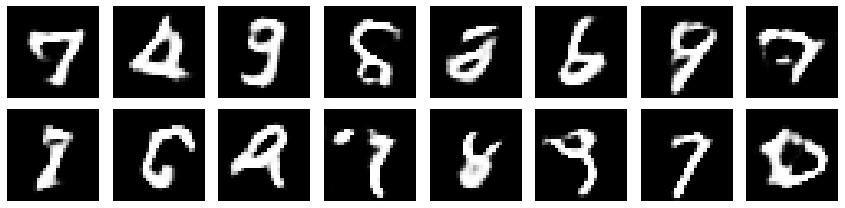

EPOCH 9 :
  [    0/60000 ( 0%)]	loss_D: 0.959, loss_G: 1.607
  [10000/60000 (17%)]	loss_D: 0.965, loss_G: 1.285
  [20000/60000 (33%)]	loss_D: 0.962, loss_G: 1.298
  [30000/60000 (50%)]	loss_D: 0.957, loss_G: 1.303
  [40000/60000 (67%)]	loss_D: 0.954, loss_G: 1.300
  [50000/60000 (83%)]	loss_D: 0.952, loss_G: 1.293


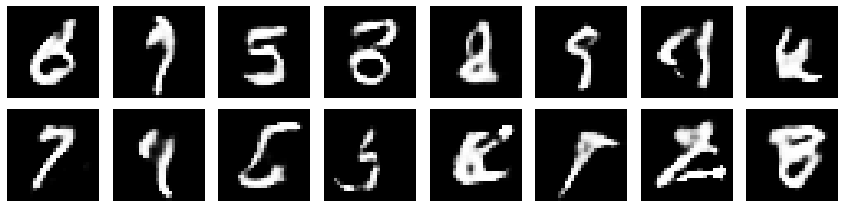

EPOCH 10 :
  [    0/60000 ( 0%)]	loss_D: 0.943, loss_G: 1.217
  [10000/60000 (17%)]	loss_D: 0.922, loss_G: 1.266
  [20000/60000 (33%)]	loss_D: 0.911, loss_G: 1.287
  [30000/60000 (50%)]	loss_D: 0.910, loss_G: 1.318
  [40000/60000 (67%)]	loss_D: 0.905, loss_G: 1.360
  [50000/60000 (83%)]	loss_D: 0.900, loss_G: 1.361


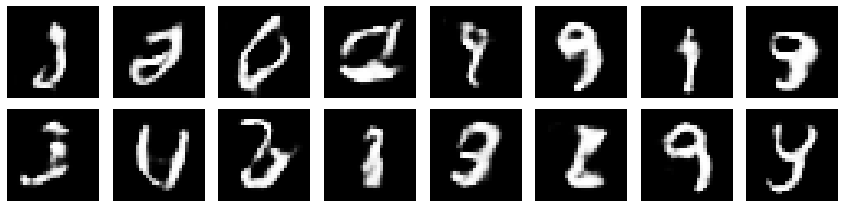

EPOCH 11 :
  [    0/60000 ( 0%)]	loss_D: 1.009, loss_G: 1.155
  [10000/60000 (17%)]	loss_D: 0.879, loss_G: 1.414
  [20000/60000 (33%)]	loss_D: 0.881, loss_G: 1.423
  [30000/60000 (50%)]	loss_D: 0.887, loss_G: 1.434
  [40000/60000 (67%)]	loss_D: 0.887, loss_G: 1.441
  [50000/60000 (83%)]	loss_D: 0.883, loss_G: 1.432


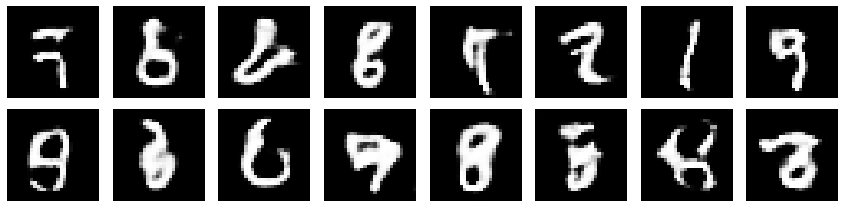

EPOCH 12 :
  [    0/60000 ( 0%)]	loss_D: 0.794, loss_G: 1.407
  [10000/60000 (17%)]	loss_D: 0.852, loss_G: 1.404
  [20000/60000 (33%)]	loss_D: 0.851, loss_G: 1.406
  [30000/60000 (50%)]	loss_D: 0.852, loss_G: 1.408
  [40000/60000 (67%)]	loss_D: 0.854, loss_G: 1.415
  [50000/60000 (83%)]	loss_D: 0.849, loss_G: 1.422


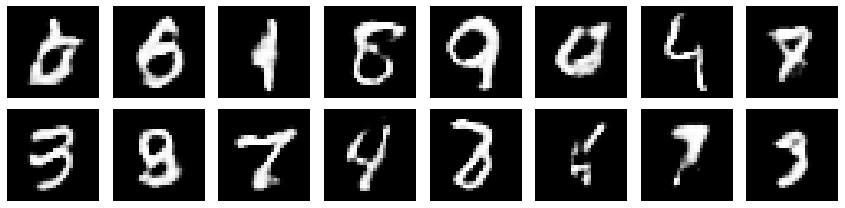

EPOCH 13 :
  [    0/60000 ( 0%)]	loss_D: 0.751, loss_G: 1.330
  [10000/60000 (17%)]	loss_D: 0.823, loss_G: 1.467
  [20000/60000 (33%)]	loss_D: 0.830, loss_G: 1.475
  [30000/60000 (50%)]	loss_D: 0.828, loss_G: 1.476
  [40000/60000 (67%)]	loss_D: 0.829, loss_G: 1.479
  [50000/60000 (83%)]	loss_D: 0.827, loss_G: 1.483


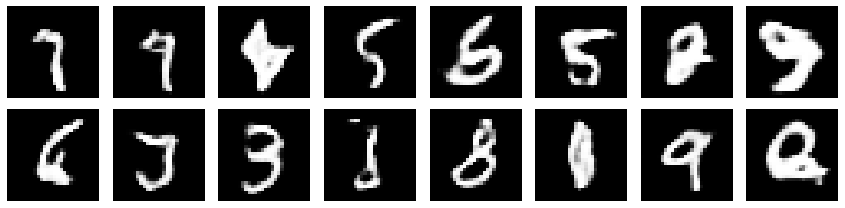

EPOCH 14 :
  [    0/60000 ( 0%)]	loss_D: 0.778, loss_G: 1.489
  [10000/60000 (17%)]	loss_D: 0.814, loss_G: 1.524
  [20000/60000 (33%)]	loss_D: 0.819, loss_G: 1.537
  [30000/60000 (50%)]	loss_D: 0.818, loss_G: 1.533
  [40000/60000 (67%)]	loss_D: 0.814, loss_G: 1.530
  [50000/60000 (83%)]	loss_D: 0.814, loss_G: 1.529


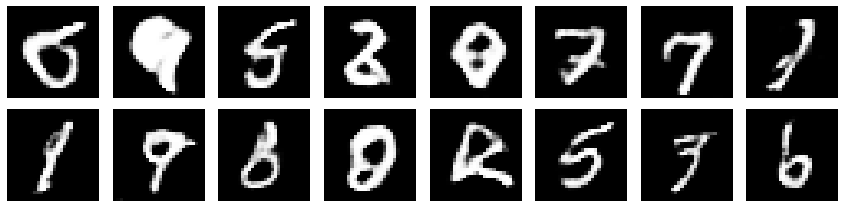

EPOCH 15 :
  [    0/60000 ( 0%)]	loss_D: 0.825, loss_G: 1.013
  [10000/60000 (17%)]	loss_D: 0.815, loss_G: 1.559
  [20000/60000 (33%)]	loss_D: 0.813, loss_G: 1.600
  [30000/60000 (50%)]	loss_D: 0.815, loss_G: 1.598
  [40000/60000 (67%)]	loss_D: 0.819, loss_G: 1.592
  [50000/60000 (83%)]	loss_D: 0.816, loss_G: 1.590


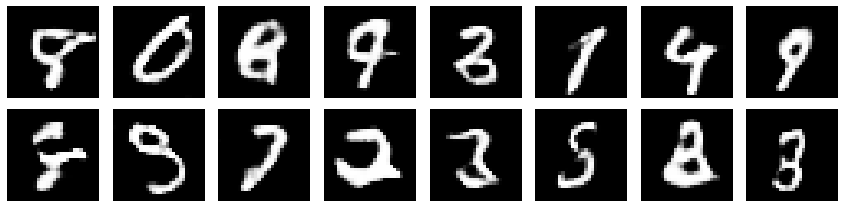

EPOCH 16 :
  [    0/60000 ( 0%)]	loss_D: 0.824, loss_G: 1.764
  [10000/60000 (17%)]	loss_D: 0.817, loss_G: 1.605
  [20000/60000 (33%)]	loss_D: 0.801, loss_G: 1.602
  [30000/60000 (50%)]	loss_D: 0.803, loss_G: 1.597
  [40000/60000 (67%)]	loss_D: 0.803, loss_G: 1.597
  [50000/60000 (83%)]	loss_D: 0.804, loss_G: 1.595


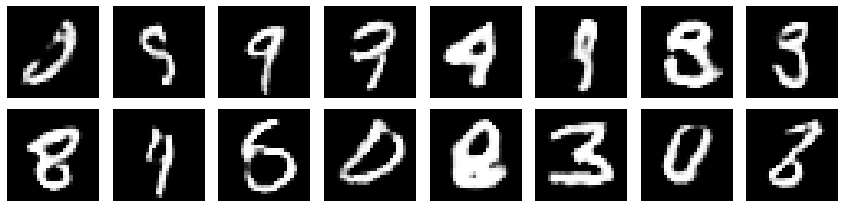

EPOCH 17 :
  [    0/60000 ( 0%)]	loss_D: 0.697, loss_G: 1.662
  [10000/60000 (17%)]	loss_D: 0.800, loss_G: 1.628
  [20000/60000 (33%)]	loss_D: 0.817, loss_G: 1.646
  [30000/60000 (50%)]	loss_D: 0.814, loss_G: 1.644
  [40000/60000 (67%)]	loss_D: 0.814, loss_G: 1.652
  [50000/60000 (83%)]	loss_D: 0.811, loss_G: 1.647


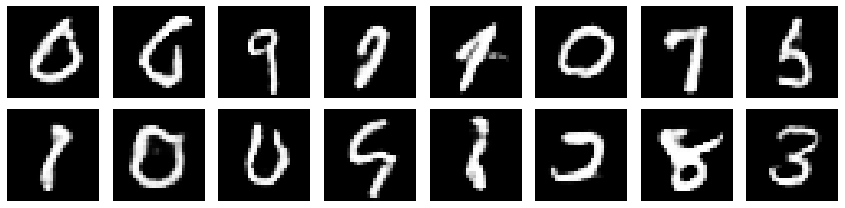

EPOCH 18 :
  [    0/60000 ( 0%)]	loss_D: 0.718, loss_G: 1.343
  [10000/60000 (17%)]	loss_D: 0.791, loss_G: 1.598
  [20000/60000 (33%)]	loss_D: 0.795, loss_G: 1.614
  [30000/60000 (50%)]	loss_D: 0.797, loss_G: 1.609
  [40000/60000 (67%)]	loss_D: 0.794, loss_G: 1.610
  [50000/60000 (83%)]	loss_D: 0.793, loss_G: 1.615


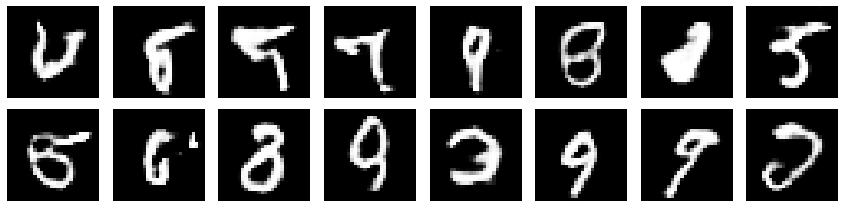

EPOCH 19 :
  [    0/60000 ( 0%)]	loss_D: 0.774, loss_G: 1.574
  [10000/60000 (17%)]	loss_D: 0.787, loss_G: 1.653
  [20000/60000 (33%)]	loss_D: 0.789, loss_G: 1.648
  [30000/60000 (50%)]	loss_D: 0.788, loss_G: 1.648
  [40000/60000 (67%)]	loss_D: 0.791, loss_G: 1.645
  [50000/60000 (83%)]	loss_D: 0.790, loss_G: 1.641


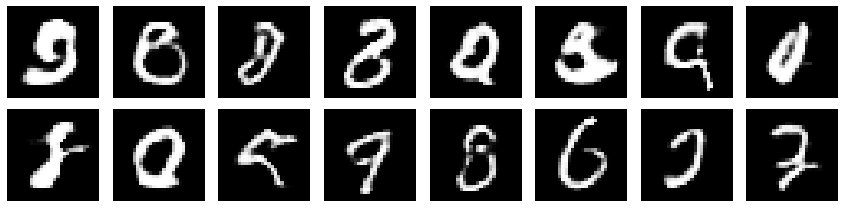

EPOCH 20 :
  [    0/60000 ( 0%)]	loss_D: 0.707, loss_G: 1.553
  [10000/60000 (17%)]	loss_D: 0.800, loss_G: 1.708
  [20000/60000 (33%)]	loss_D: 0.798, loss_G: 1.691
  [30000/60000 (50%)]	loss_D: 0.794, loss_G: 1.672
  [40000/60000 (67%)]	loss_D: 0.796, loss_G: 1.673
  [50000/60000 (83%)]	loss_D: 0.792, loss_G: 1.672


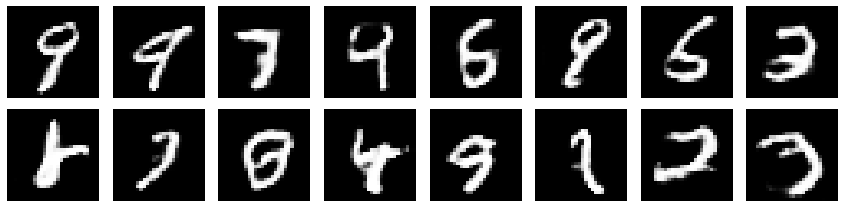

In [33]:
n_epoch = 20
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    print('EPOCH %d :' % epoch)
    for batch_idx, (x, _) in enumerate(train_loader):
        loss_D = D_train_DCGAN(x)
        D_losses.append(loss_D)
        loss_G = G_train_DCGAN()
        G_losses.append(loss_G)
        
        if batch_idx % 100 == 0:
            print('  [{:5d}/{} ({:2.0f}%)]\tloss_D: {:.3f}, loss_G: {:.3f}'.format(batch_idx * len(x), len(train_loader.dataset), 100. * batch_idx / len(train_loader), torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G_DCGAN(test_z)
        sub_generated = generated[:16,:]
        plotGeneratedImages(sub_generated.view(sub_generated.size(0), 1, 28, 28),dim=(2, 8),figsize=(12,3))

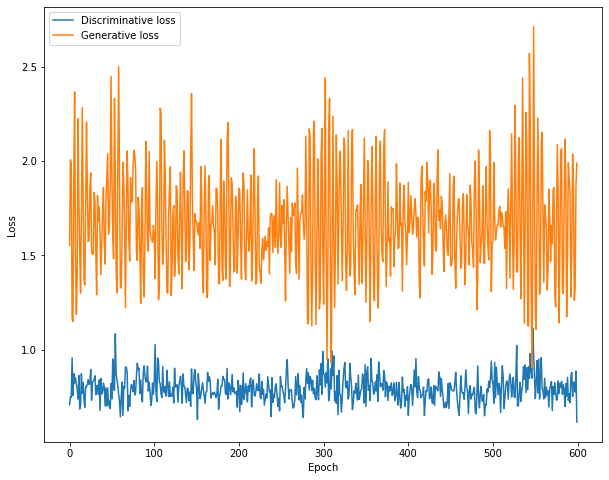

In [35]:
plotLoss(D_losses, G_losses)